## In this notebook, the goal is to classify whether a person's hand is in synchronised, alone or spontanious position using ML.

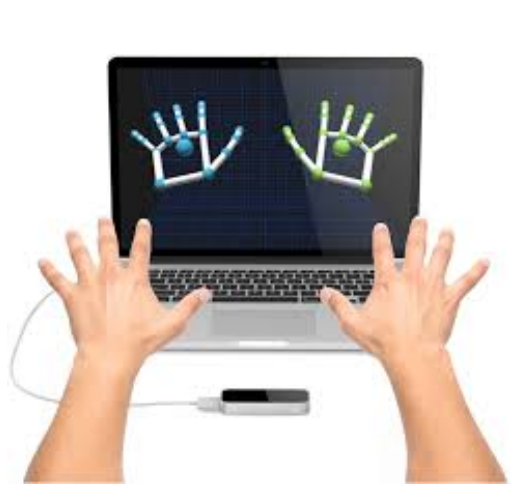

In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
import pandas as pd
import os
import cv2
from pandas import Series
import seaborn as sns

## The data is spread across a few files, so I need to collect them all to three datasets for training and three for testing.

### First, the syncronised mode:
### As you can see, I also got rid of the first seven seconds of each .csv file.

In [2]:
sync_train = []
file_path = r'C:\Users\yaron\Data Science\Training'
for file1 in os.listdir(file_path):
    if file1.endswith('Sync.csv'):
        sync_train.append(os.path.join(r'C:\Users\yaron\Data Science\Training', file1))
        
df_train_sync = pd.DataFrame()        
for file in sync_train:
    df1 = pd.read_csv(file)
    after_seven1 = df1['Time'] > (df1['Time'][0])+7
    df_after_seven1 = df1[after_seven1]
    df_after_seven1.reset_index(drop=True,inplace=True)
    df_after_seven1
    df_train_sync = pd.concat([df_train_sync,df_after_seven1])

In [3]:
df_train_sync.reset_index(drop=True,inplace=True)
df_train_sync 

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,434.2387,139878,right,2,121.96880,230.3867,61.918910,7.82505,-222.59100,121.91490,...,-0.320716,143.0681,170.9626,92.10286,290.9513,-17.46554,156.27410,0.0,0.036538,0.0
1,434.2387,139878,left,2,-80.92312,284.2069,29.011070,84.47700,-45.59256,134.20850,...,0.624079,-107.3702,221.7536,46.12994,-254.8560,22.47225,40.89467,0.0,0.000000,0.0
2,434.2553,139880,right,2,121.61940,226.1235,64.109630,-32.32643,-248.08270,109.73410,...,-0.333641,143.3853,166.9691,94.34527,293.7114,-20.13464,156.68940,0.0,0.001488,0.0
3,434.2553,139880,left,2,-79.71033,282.4789,31.691100,55.75132,-119.51820,158.45370,...,0.653397,-106.8187,220.1253,48.09507,-258.4003,23.92692,43.43317,0.0,0.000000,0.0
4,434.2718,139882,right,2,121.03880,222.2049,65.984120,-28.86916,-210.96420,109.70620,...,-0.344350,143.3656,163.3614,96.39383,296.6688,-21.13594,159.25370,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68824,856.2631,67309,right,2,101.91230,212.0264,42.535680,79.95810,113.41030,190.77140,...,-0.574317,131.8590,149.6264,66.09853,283.6185,-58.03491,95.29868,0.0,0.000000,0.0
68825,856.2958,67311,left,2,-81.57359,183.5054,-7.185198,-63.24731,121.75270,62.95970,...,0.459446,-109.7250,130.7078,34.03360,-295.5957,-14.97817,140.02630,0.0,0.000000,0.0
68826,856.2958,67311,right,2,103.84750,214.7484,47.070820,61.11773,95.13531,155.74530,...,-0.612753,134.0416,151.5924,68.17693,288.9688,-54.13820,94.23959,0.0,0.000000,0.0
68827,856.3295,67314,left,2,-84.05124,187.8450,-5.172269,-57.17249,109.20360,58.48146,...,0.434273,-109.5167,131.6489,33.32945,-282.9649,-31.35462,135.07610,0.0,0.000000,0.0


### The hand type is important for the dataset, as it is placed diffirently from the right hand and it's pixel values are completely different, the easiest way to set apart the left hand data from the right hand data is pd.get_dummies:

In [4]:
df_train_sync = pd.get_dummies(df_train_sync)
df_train_sync

,Time,Frame ID,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,...,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength,Hand Type_left,Hand Type_right
0,434.2387,139878,2,121.96880,230.3867,61.918910,7.82505,-222.59100,121.91490,0.959785,...,170.9626,92.10286,290.9513,-17.46554,156.27410,0.0,0.036538,0.0,0,1
1,434.2387,139878,2,-80.92312,284.2069,29.011070,84.47700,-45.59256,134.20850,1.128240,...,221.7536,46.12994,-254.8560,22.47225,40.89467,0.0,0.000000,0.0,1,0
2,434.2553,139880,2,121.61940,226.1235,64.109630,-32.32643,-248.08270,109.73410,0.956199,...,166.9691,94.34527,293.7114,-20.13464,156.68940,0.0,0.001488,0.0,0,1
3,434.2553,139880,2,-79.71033,282.4789,31.691100,55.75132,-119.51820,158.45370,1.139780,...,220.1253,48.09507,-258.4003,23.92692,43.43317,0.0,0.000000,0.0,1,0
4,434.2718,139882,2,121.03880,222.2049,65.984120,-28.86916,-210.96420,109.70620,0.951746,...,163.3614,96.39383,296.6688,-21.13594,159.25370,0.0,0.000000,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68824,856.2631,67309,2,101.91230,212.0264,42.535680,79.95810,113.41030,190.77140,1.065334,...,149.6264,66.09853,283.6185,-58.03491,95.29868,0.0,0.000000,0.0,0,1
68825,856.2958,67311,2,-81.57359,183.5054,-7.185198,-63.24731,121.75270,62.95970,0.762549,...,130.7078,34.03360,-295.5957,-14.97817,140.02630,0.0,0.000000,0.0,1,0
68826,856.2958,67311,2,103.84750,214.7484,47.070820,61.11773,95.13531,155.74530,1.110287,...,151.5924,68.17693,288.9688,-54.13820,94.23959,0.0,0.000000,0.0,0,1
68827,856.3295,67314,2,-84.05124,187.8450,-5.172269,-57.17249,109.20360,58.48146,0.824793,...,131.6489,33.32945,-282.9649,-31.35462,135.07610,0.0,0.000000,0.0,1,0


In [5]:
df_train_sync.isna().sum()

Time                0
 Frame ID           0
 # hands            0
 Position X         0
 Position Y         0
 Position Z         0
 Velocity X         0
 Velocity Y         0
 Velocity Z         0
 Pitch              0
 Roll               0
 Yaw                0
 Wrist Pos X        0
 Wrist Pos Y        0
 Wrist Pos Z        0
 Elbow pos X        0
 Elbow Pos Y        0
 Elbow Pos Z        0
 Grab Strenth       0
 Grab Angle         0
 Pinch Strength     0
 Hand Type_left     0
 Hand Type_right    0
dtype: int64

In [6]:
df_train_sync.duplicated().sum()

0

### Renaming some columns as a convience. Also I made a 'Category' label, since this is what I'm trying to classify.

In [7]:
df_train_sync = df_train_sync.rename(columns={' Frame ID': 'Frame_ID', ' Hand Type_left': 'Hand_Type_left',' Hand Type_right': 'Hand_Type_right',
                                  ' # hands':'Number_of_hands', ' Position X': 'Position_X', ' Position Y': 'Position_Y',
                                ' Position Z': 'Position_Z', ' Velocity X': 'Velocity_X', ' Velocity Y': 'Velocity_Y',
                                ' Velocity Z': 'Velocity_Z', ' Wrist Pos X': 'Wrist_Pos_X', ' Wrist Pos Y': 'Wrist_Pos_Y', ' Wrist Pos Z': 'Wrist_Pos_Z',
                                 ' Elbow pos X': 'Elbow_Pos_X',  ' Elbow Pos Y':  'Elbow_Pos_Y', ' Elbow Pos Z': 'Elbow_Pos_Z',
                                 ' Grab Strenth': 'Grab_Strenth', ' Grab Angle': 'Grab_Angle', ' Pinch Strength': 'Pinch_Strength'})
df_train_sync['Category'] = '0'
df_train_sync

,Time,Frame_ID,Number_of_hands,Position_X,Position_Y,Position_Z,Velocity_X,Velocity_Y,Velocity_Z,Pitch,...,Wrist_Pos_Z,Elbow_Pos_X,Elbow_Pos_Y,Elbow_Pos_Z,Grab_Strenth,Grab_Angle,Pinch_Strength,Hand_Type_left,Hand_Type_right,Category
0,434.2387,139878,2,121.96880,230.3867,61.918910,7.82505,-222.59100,121.91490,0.959785,...,92.10286,290.9513,-17.46554,156.27410,0.0,0.036538,0.0,0,1,0
1,434.2387,139878,2,-80.92312,284.2069,29.011070,84.47700,-45.59256,134.20850,1.128240,...,46.12994,-254.8560,22.47225,40.89467,0.0,0.000000,0.0,1,0,0
2,434.2553,139880,2,121.61940,226.1235,64.109630,-32.32643,-248.08270,109.73410,0.956199,...,94.34527,293.7114,-20.13464,156.68940,0.0,0.001488,0.0,0,1,0
3,434.2553,139880,2,-79.71033,282.4789,31.691100,55.75132,-119.51820,158.45370,1.139780,...,48.09507,-258.4003,23.92692,43.43317,0.0,0.000000,0.0,1,0,0
4,434.2718,139882,2,121.03880,222.2049,65.984120,-28.86916,-210.96420,109.70620,0.951746,...,96.39383,296.6688,-21.13594,159.25370,0.0,0.000000,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68824,856.2631,67309,2,101.91230,212.0264,42.535680,79.95810,113.41030,190.77140,1.065334,...,66.09853,283.6185,-58.03491,95.29868,0.0,0.000000,0.0,0,1,0
68825,856.2958,67311,2,-81.57359,183.5054,-7.185198,-63.24731,121.75270,62.95970,0.762549,...,34.03360,-295.5957,-14.97817,140.02630,0.0,0.000000,0.0,1,0,0
68826,856.2958,67311,2,103.84750,214.7484,47.070820,61.11773,95.13531,155.74530,1.110287,...,68.17693,288.9688,-54.13820,94.23959,0.0,0.000000,0.0,0,1,0
68827,856.3295,67314,2,-84.05124,187.8450,-5.172269,-57.17249,109.20360,58.48146,0.824793,...,33.32945,-282.9649,-31.35462,135.07610,0.0,0.000000,0.0,1,0,0


In [8]:
(df_train_sync['Number_of_hands'] == 1).sum()

741

In [9]:
df_train_sync.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68829 entries, 0 to 68828
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             68829 non-null  float64
 1   Frame_ID         68829 non-null  int64  
 2   Number_of_hands  68829 non-null  int64  
 3   Position_X       68829 non-null  float64
 4   Position_Y       68829 non-null  float64
 5   Position_Z       68829 non-null  float64
 6   Velocity_X       68829 non-null  float64
 7   Velocity_Y       68829 non-null  float64
 8   Velocity_Z       68829 non-null  float64
 9    Pitch           68829 non-null  float64
 10   Roll            68829 non-null  float64
 11   Yaw             68829 non-null  float64
 12  Wrist_Pos_X      68829 non-null  float64
 13  Wrist_Pos_Y      68829 non-null  float64
 14  Wrist_Pos_Z      68829 non-null  float64
 15  Elbow_Pos_X      68829 non-null  float64
 16  Elbow_Pos_Y      68829 non-null  float64
 17  Elbow_Pos_Z 

### Now, the alone mode:
### As you can see, I also got rid of the first seven seconds of each .csv file.

In [10]:
alone_train = []
for file2 in os.listdir(file_path):
    if file2.endswith('Alone.csv'):
        alone_train.append(os.path.join(r'C:\Users\yaron\Data Science\Training', file2))
        df_train_alone = pd.DataFrame()
for file in alone_train:
    df2 = pd.read_csv(file)
    after_seven2 = df2['Time'] > (df2['Time'][0])+7
    df_after_seven2 = df2[after_seven2]
    df_after_seven2.reset_index(drop=True,inplace=True)
    df_after_seven2
    df_train_alone = pd.concat([df_train_alone,df_after_seven2])


In [11]:
df_train_alone.reset_index(drop=True,inplace=True)
df_train_alone 

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,525.8185,150428,left,1,-52.96039,184.5535,-2.856696,162.152700,127.605200,-85.837820,...,1.199751,-101.04550,132.5940,4.449887,-307.7127,-12.177800,5.125422,0.000000,0.073635,0.000000
1,525.8351,150430,left,1,-50.04434,185.5024,-4.845364,102.824800,-24.843370,-79.465040,...,1.171960,-95.51471,131.5824,2.853924,-313.0367,3.746006,-0.704697,0.000000,0.018766,0.000000
2,525.8516,150432,left,1,-49.07749,182.2930,-6.442950,12.123600,-258.752600,-99.409020,...,1.152816,-94.32024,128.7403,2.742160,-322.1467,20.402740,-2.617105,0.000000,0.018409,0.000000
3,525.8682,150434,left,1,-50.89614,176.7708,-9.005262,-53.572920,-271.015000,-143.033300,...,1.114818,-99.72611,127.6519,5.047988,-331.5826,28.883190,-7.521224,0.000000,0.149852,0.000000
4,525.8848,150436,left,1,-51.76074,174.1853,-10.600340,-40.958830,-140.443900,-59.856200,...,1.091361,-102.66840,128.2257,6.734126,-333.9562,27.848030,-3.312394,0.000000,0.242324,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35029,764.4578,59984,left,1,-125.81370,214.8894,20.593240,20.170870,19.997410,37.082170,...,0.409534,-146.63140,148.2971,44.407660,-258.0887,-77.529710,112.970600,0.116069,1.901876,0.000000
35030,764.4913,59986,left,1,-125.92320,215.6769,22.092640,-6.867068,21.957800,42.485630,...,0.399021,-146.11130,148.8045,45.689300,-253.6847,-80.136250,109.996700,0.134497,1.952747,0.000000
35031,764.5253,59988,left,1,-125.62170,215.7428,23.397500,17.454730,-3.217659,31.446690,...,0.379251,-144.81740,148.4588,46.660750,-249.6531,-83.331760,105.004300,0.120680,1.984825,0.000000
35032,764.5587,59989,left,1,-125.13520,215.6353,23.802480,25.567410,-5.648659,21.284490,...,0.368866,-143.84820,148.1024,46.728610,-248.2768,-84.269360,103.468300,0.097735,1.988376,0.000000


### This part is trickier, because the right and left hand files are apart, so I unified them:

In [12]:
alone2 = pd.read_csv(r'C:\Users\yaron\Data Science\Training\HandRight.csv')

In [13]:
after_seven3 = alone2['Time'] > (alone2['Time'][0])+7
df_after_seven3 = alone2[after_seven3]
df_after_seven3.reset_index(drop=True,inplace=True)
alone2 = df_after_seven3
alone2

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,135.3024,16287,right,1,11.930320,199.9861,4.981665,-35.512210,-165.3466,-57.68153,...,-0.906612,75.45740,206.0521,45.38764,284.3946,140.0167,201.9318,0.0,0.561324,0.0
1,135.3194,16289,right,1,11.191900,195.3075,3.661716,-43.587440,-309.8374,-77.18515,...,-0.904311,74.46141,202.4562,44.28679,282.6278,140.9712,203.6773,0.0,0.626321,0.0
2,135.3357,16291,right,1,10.533080,189.0297,2.829388,-30.403600,-363.0033,-43.79815,...,-0.901862,73.60060,197.4387,43.54082,280.6384,142.5401,206.7526,0.0,0.636596,0.0
3,135.3524,16293,right,1,10.243000,181.9816,2.064330,-15.424000,-423.2120,-43.99948,...,-0.901268,73.19537,191.7202,42.73155,279.7357,148.1382,209.9330,0.0,0.701644,0.0
4,135.3690,16295,right,1,10.020610,174.8592,1.228467,-8.733602,-413.4513,-53.88054,...,-0.897777,72.68671,186.1613,41.98006,278.6890,152.5215,212.1112,0.0,0.786548,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4386,208.1942,24687,right,1,-15.404800,208.0276,9.980799,167.862400,510.0852,-105.52950,...,-0.282299,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.503490,0.0
4387,208.2108,24689,right,1,-12.678650,218.1196,9.314082,145.009700,562.3594,-20.70701,...,-0.263492,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.403687,0.0
4388,208.2276,24691,right,1,-9.643562,228.2807,9.722980,180.421600,591.9019,28.88057,...,-0.234337,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.310940,0.0
4389,208.2443,24692,right,1,-7.980715,233.5056,10.419080,192.459300,604.7344,80.56698,...,-0.222084,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.286526,0.0


In [14]:
df_train_alone = pd.concat([alone2, df_train_alone])
df_train_alone

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,135.3024,16287,right,1,11.93032,199.9861,4.981665,-35.512210,-165.346600,-57.681530,...,-0.906612,75.45740,206.0521,45.38764,284.3946,140.01670,201.9318,0.000000,0.561324,0.000000
1,135.3194,16289,right,1,11.19190,195.3075,3.661716,-43.587440,-309.837400,-77.185150,...,-0.904311,74.46141,202.4562,44.28679,282.6278,140.97120,203.6773,0.000000,0.626321,0.000000
2,135.3357,16291,right,1,10.53308,189.0297,2.829388,-30.403600,-363.003300,-43.798150,...,-0.901862,73.60060,197.4387,43.54082,280.6384,142.54010,206.7526,0.000000,0.636596,0.000000
3,135.3524,16293,right,1,10.24300,181.9816,2.064330,-15.424000,-423.212000,-43.999480,...,-0.901268,73.19537,191.7202,42.73155,279.7357,148.13820,209.9330,0.000000,0.701644,0.000000
4,135.3690,16295,right,1,10.02061,174.8592,1.228467,-8.733602,-413.451300,-53.880540,...,-0.897777,72.68671,186.1613,41.98006,278.6890,152.52150,212.1112,0.000000,0.786548,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35029,764.4578,59984,left,1,-125.81370,214.8894,20.593240,20.170870,19.997410,37.082170,...,0.409534,-146.63140,148.2971,44.40766,-258.0887,-77.52971,112.9706,0.116069,1.901876,0.000000
35030,764.4913,59986,left,1,-125.92320,215.6769,22.092640,-6.867068,21.957800,42.485630,...,0.399021,-146.11130,148.8045,45.68930,-253.6847,-80.13625,109.9967,0.134497,1.952747,0.000000
35031,764.5253,59988,left,1,-125.62170,215.7428,23.397500,17.454730,-3.217659,31.446690,...,0.379251,-144.81740,148.4588,46.66075,-249.6531,-83.33176,105.0043,0.120680,1.984825,0.000000
35032,764.5587,59989,left,1,-125.13520,215.6353,23.802480,25.567410,-5.648659,21.284490,...,0.368866,-143.84820,148.1024,46.72861,-248.2768,-84.26936,103.4683,0.097735,1.988376,0.000000


In [15]:
df_train_alone = pd.get_dummies(df_train_alone)
df_train_alone

,Time,Frame ID,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,...,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength,Hand Type_left,Hand Type_right
0,135.3024,16287,1,11.93032,199.9861,4.981665,-35.512210,-165.346600,-57.681530,-0.092033,...,206.0521,45.38764,284.3946,140.01670,201.9318,0.000000,0.561324,0.000000,0,1
1,135.3194,16289,1,11.19190,195.3075,3.661716,-43.587440,-309.837400,-77.185150,-0.111674,...,202.4562,44.28679,282.6278,140.97120,203.6773,0.000000,0.626321,0.000000,0,1
2,135.3357,16291,1,10.53308,189.0297,2.829388,-30.403600,-363.003300,-43.798150,-0.140004,...,197.4387,43.54082,280.6384,142.54010,206.7526,0.000000,0.636596,0.000000,0,1
3,135.3524,16293,1,10.24300,181.9816,2.064330,-15.424000,-423.212000,-43.999480,-0.166623,...,191.7202,42.73155,279.7357,148.13820,209.9330,0.000000,0.701644,0.000000,0,1
4,135.3690,16295,1,10.02061,174.8592,1.228467,-8.733602,-413.451300,-53.880540,-0.197763,...,186.1613,41.98006,278.6890,152.52150,212.1112,0.000000,0.786548,0.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35029,764.4578,59984,1,-125.81370,214.8894,20.593240,20.170870,19.997410,37.082170,1.099869,...,148.2971,44.40766,-258.0887,-77.52971,112.9706,0.116069,1.901876,0.000000,1,0
35030,764.4913,59986,1,-125.92320,215.6769,22.092640,-6.867068,21.957800,42.485630,1.100429,...,148.8045,45.68930,-253.6847,-80.13625,109.9967,0.134497,1.952747,0.000000,1,0
35031,764.5253,59988,1,-125.62170,215.7428,23.397500,17.454730,-3.217659,31.446690,1.101742,...,148.4588,46.66075,-249.6531,-83.33176,105.0043,0.120680,1.984825,0.000000,1,0
35032,764.5587,59989,1,-125.13520,215.6353,23.802480,25.567410,-5.648659,21.284490,1.107025,...,148.1024,46.72861,-248.2768,-84.26936,103.4683,0.097735,1.988376,0.000000,1,0


In [16]:
df_train_alone = df_train_alone.rename(columns={' Frame ID': 'Frame_ID', ' Hand Type_left': 'Hand_Type_left', ' Hand Type_right': 'Hand_Type_right',
                                  ' # hands':'Number_of_hands', ' Position X': 'Position_X', ' Position Y': 'Position_Y',
                                ' Position Z': 'Position_Z', ' Velocity X': 'Velocity_X', ' Velocity Y': 'Velocity_Y',
                                ' Velocity Z': 'Velocity_Z', ' Wrist Pos X': 'Wrist_Pos_X', ' Wrist Pos Y': 'Wrist_Pos_Y', ' Wrist Pos Z': 'Wrist_Pos_Z',
                                 ' Elbow pos X': 'Elbow_Pos_X', ' Elbow Pos Y':  'Elbow_Pos_Y', ' Elbow Pos Z': 'Elbow_Pos_Z',
                                 ' Grab Strenth': 'Grab_Strenth', ' Grab Angle': 'Grab_Angle', ' Pinch Strength': 'Pinch_Strength'})
df_train_alone['Category'] = '1'
df_train_alone

,Time,Frame_ID,Number_of_hands,Position_X,Position_Y,Position_Z,Velocity_X,Velocity_Y,Velocity_Z,Pitch,...,Wrist_Pos_Z,Elbow_Pos_X,Elbow_Pos_Y,Elbow_Pos_Z,Grab_Strenth,Grab_Angle,Pinch_Strength,Hand_Type_left,Hand_Type_right,Category
0,135.3024,16287,1,11.93032,199.9861,4.981665,-35.512210,-165.346600,-57.681530,-0.092033,...,45.38764,284.3946,140.01670,201.9318,0.000000,0.561324,0.000000,0,1,1
1,135.3194,16289,1,11.19190,195.3075,3.661716,-43.587440,-309.837400,-77.185150,-0.111674,...,44.28679,282.6278,140.97120,203.6773,0.000000,0.626321,0.000000,0,1,1
2,135.3357,16291,1,10.53308,189.0297,2.829388,-30.403600,-363.003300,-43.798150,-0.140004,...,43.54082,280.6384,142.54010,206.7526,0.000000,0.636596,0.000000,0,1,1
3,135.3524,16293,1,10.24300,181.9816,2.064330,-15.424000,-423.212000,-43.999480,-0.166623,...,42.73155,279.7357,148.13820,209.9330,0.000000,0.701644,0.000000,0,1,1
4,135.3690,16295,1,10.02061,174.8592,1.228467,-8.733602,-413.451300,-53.880540,-0.197763,...,41.98006,278.6890,152.52150,212.1112,0.000000,0.786548,0.000000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35029,764.4578,59984,1,-125.81370,214.8894,20.593240,20.170870,19.997410,37.082170,1.099869,...,44.40766,-258.0887,-77.52971,112.9706,0.116069,1.901876,0.000000,1,0,1
35030,764.4913,59986,1,-125.92320,215.6769,22.092640,-6.867068,21.957800,42.485630,1.100429,...,45.68930,-253.6847,-80.13625,109.9967,0.134497,1.952747,0.000000,1,0,1
35031,764.5253,59988,1,-125.62170,215.7428,23.397500,17.454730,-3.217659,31.446690,1.101742,...,46.66075,-249.6531,-83.33176,105.0043,0.120680,1.984825,0.000000,1,0,1
35032,764.5587,59989,1,-125.13520,215.6353,23.802480,25.567410,-5.648659,21.284490,1.107025,...,46.72861,-248.2768,-84.26936,103.4683,0.097735,1.988376,0.000000,1,0,1


### Lastly, the spontanious mode:
### As you can see, I also got rid of the first seven seconds of each .csv file.

In [17]:
spontan_train = []
for file3 in os.listdir(file_path):
    if file3.endswith('Spontan.csv'):
        spontan_train.append(os.path.join(r'C:\Users\yaron\Data Science\Training', file3))
        df_train_spontan = pd.DataFrame()
for file in spontan_train:
    df4 = pd.read_csv(file)
    after_seven4 = df4['Time'] > (df4['Time'][0])+7
    df_after_seven4 = df4[after_seven4]
    df_after_seven4.reset_index(drop=True,inplace=True)
    df_after_seven4
    df_train_spontan = pd.concat([df_train_spontan,df_after_seven4])


In [18]:
df_train_spontan.reset_index(drop=True,inplace=True)
df_train_spontan

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,343.0061,129364,right,2,152.31350,204.6813,-39.256710,-28.56766,23.00662,8.315823,...,-0.563396,191.4088,170.3479,8.976357,323.5327,21.27053,162.709900,1.0,2.793122,0.329752
1,343.0061,129364,left,2,-102.28700,198.3166,-2.122641,-174.57210,379.14680,28.479910,...,1.481006,-164.0542,164.5314,-1.686393,-322.2086,-30.71549,11.754400,0.0,1.870325,0.000000
2,343.0227,129365,right,2,151.83340,204.4899,-39.084380,-54.05849,-21.54555,19.405560,...,-0.560823,190.8670,170.1528,9.191355,323.1941,20.16283,161.858900,1.0,2.704073,0.293775
3,343.0227,129365,left,2,-103.87210,201.4944,-2.063620,-178.50250,357.85480,6.646493,...,1.486744,-165.7898,168.1620,-2.054844,-318.4708,-31.61653,7.529989,0.0,1.851572,0.000000
4,343.0392,129367,right,2,151.40560,203.4883,-38.142800,-14.11075,-56.44812,68.092860,...,-0.554623,190.4547,169.7302,10.512530,324.1130,19.09524,161.374600,1.0,2.422549,0.175940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69048,673.4894,52512,left,2,-81.66566,203.9826,24.040280,240.80950,-160.56200,-222.444200,...,0.845894,-121.2401,146.1889,44.914080,-263.3239,-65.38571,89.689400,0.0,1.299514,0.000000
69049,673.5233,52516,right,2,158.51870,172.6876,-29.329130,62.95145,93.99306,-63.022420,...,-0.452287,200.4651,148.9561,25.427530,400.5782,31.01108,139.279600,0.0,0.448368,0.000000
69050,673.5233,52516,left,2,-77.57621,198.9182,20.579730,127.00290,-218.65710,-80.403090,...,0.827028,-120.1531,144.5244,44.439020,-276.8819,-56.07000,90.445170,0.0,0.542512,0.000000
69051,673.5560,52519,right,2,159.35720,175.7603,-30.162820,10.30027,118.67660,-7.947631,...,-0.432002,199.5587,149.5821,24.801710,390.8217,24.22654,145.633700,0.0,0.513919,0.000000


In [19]:
df_train_spontan = pd.get_dummies(df_train_spontan)
df_train_spontan

,Time,Frame ID,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,...,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength,Hand Type_left,Hand Type_right
0,343.0061,129364,2,152.31350,204.6813,-39.256710,-28.56766,23.00662,8.315823,0.654996,...,170.3479,8.976357,323.5327,21.27053,162.709900,1.0,2.793122,0.329752,0,1
1,343.0061,129364,2,-102.28700,198.3166,-2.122641,-174.57210,379.14680,28.479910,1.423625,...,164.5314,-1.686393,-322.2086,-30.71549,11.754400,0.0,1.870325,0.000000,1,0
2,343.0227,129365,2,151.83340,204.4899,-39.084380,-54.05849,-21.54555,19.405560,0.652891,...,170.1528,9.191355,323.1941,20.16283,161.858900,1.0,2.704073,0.293775,0,1
3,343.0227,129365,2,-103.87210,201.4944,-2.063620,-178.50250,357.85480,6.646493,1.429039,...,168.1620,-2.054844,-318.4708,-31.61653,7.529989,0.0,1.851572,0.000000,1,0
4,343.0392,129367,2,151.40560,203.4883,-38.142800,-14.11075,-56.44812,68.092860,0.637780,...,169.7302,10.512530,324.1130,19.09524,161.374600,1.0,2.422549,0.175940,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69048,673.4894,52512,2,-81.66566,203.9826,24.040280,240.80950,-160.56200,-222.444200,1.124147,...,146.1889,44.914080,-263.3239,-65.38571,89.689400,0.0,1.299514,0.000000,1,0
69049,673.5233,52516,2,158.51870,172.6876,-29.329130,62.95145,93.99306,-63.022420,0.323673,...,148.9561,25.427530,400.5782,31.01108,139.279600,0.0,0.448368,0.000000,0,1
69050,673.5233,52516,2,-77.57621,198.9182,20.579730,127.00290,-218.65710,-80.403090,1.037299,...,144.5244,44.439020,-276.8819,-56.07000,90.445170,0.0,0.542512,0.000000,1,0
69051,673.5560,52519,2,159.35720,175.7603,-30.162820,10.30027,118.67660,-7.947631,0.365282,...,149.5821,24.801710,390.8217,24.22654,145.633700,0.0,0.513919,0.000000,0,1


In [20]:
df_train_spontan = df_train_spontan.rename(columns={' Frame ID': 'Frame_ID', ' Hand Type_left': 'Hand_Type_left', ' Hand Type_right': 'Hand_Type_right',
                                  ' # hands':'Number_of_hands', ' Position X': 'Position_X', ' Position Y': 'Position_Y',
                                ' Position Z': 'Position_Z', ' Velocity X': 'Velocity_X', ' Velocity Y': 'Velocity_Y',
                                ' Velocity Z': 'Velocity_Z', ' Wrist Pos X': 'Wrist_Pos_X', ' Wrist Pos Y': 'Wrist_Pos_Y', ' Wrist Pos Z': 'Wrist_Pos_Z',
                                 ' Elbow pos X': 'Elbow_Pos_X', ' Elbow Pos Y':  'Elbow_Pos_Y', ' Elbow Pos Z': 'Elbow_Pos_Z',
                                 ' Grab Strenth': 'Grab_Strenth', ' Grab Angle': 'Grab_Angle', ' Pinch Strength': 'Pinch_Strength'})
df_train_spontan['Category'] = '2'
df_train_spontan

,Time,Frame_ID,Number_of_hands,Position_X,Position_Y,Position_Z,Velocity_X,Velocity_Y,Velocity_Z,Pitch,...,Wrist_Pos_Z,Elbow_Pos_X,Elbow_Pos_Y,Elbow_Pos_Z,Grab_Strenth,Grab_Angle,Pinch_Strength,Hand_Type_left,Hand_Type_right,Category
0,343.0061,129364,2,152.31350,204.6813,-39.256710,-28.56766,23.00662,8.315823,0.654996,...,8.976357,323.5327,21.27053,162.709900,1.0,2.793122,0.329752,0,1,2
1,343.0061,129364,2,-102.28700,198.3166,-2.122641,-174.57210,379.14680,28.479910,1.423625,...,-1.686393,-322.2086,-30.71549,11.754400,0.0,1.870325,0.000000,1,0,2
2,343.0227,129365,2,151.83340,204.4899,-39.084380,-54.05849,-21.54555,19.405560,0.652891,...,9.191355,323.1941,20.16283,161.858900,1.0,2.704073,0.293775,0,1,2
3,343.0227,129365,2,-103.87210,201.4944,-2.063620,-178.50250,357.85480,6.646493,1.429039,...,-2.054844,-318.4708,-31.61653,7.529989,0.0,1.851572,0.000000,1,0,2
4,343.0392,129367,2,151.40560,203.4883,-38.142800,-14.11075,-56.44812,68.092860,0.637780,...,10.512530,324.1130,19.09524,161.374600,1.0,2.422549,0.175940,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69048,673.4894,52512,2,-81.66566,203.9826,24.040280,240.80950,-160.56200,-222.444200,1.124147,...,44.914080,-263.3239,-65.38571,89.689400,0.0,1.299514,0.000000,1,0,2
69049,673.5233,52516,2,158.51870,172.6876,-29.329130,62.95145,93.99306,-63.022420,0.323673,...,25.427530,400.5782,31.01108,139.279600,0.0,0.448368,0.000000,0,1,2
69050,673.5233,52516,2,-77.57621,198.9182,20.579730,127.00290,-218.65710,-80.403090,1.037299,...,44.439020,-276.8819,-56.07000,90.445170,0.0,0.542512,0.000000,1,0,2
69051,673.5560,52519,2,159.35720,175.7603,-30.162820,10.30027,118.67660,-7.947631,0.365282,...,24.801710,390.8217,24.22654,145.633700,0.0,0.513919,0.000000,0,1,2


## Merge 'em all (to one dataset)

In [21]:
df_train = pd.concat([df_train_sync, df_train_alone], axis=0, ignore_index=True)
df_train = pd.concat([df_train, df_train_spontan], axis=0, ignore_index=True)
df_train

,Time,Frame_ID,Number_of_hands,Position_X,Position_Y,Position_Z,Velocity_X,Velocity_Y,Velocity_Z,Pitch,...,Wrist_Pos_Z,Elbow_Pos_X,Elbow_Pos_Y,Elbow_Pos_Z,Grab_Strenth,Grab_Angle,Pinch_Strength,Hand_Type_left,Hand_Type_right,Category
0,434.2387,139878,2,121.96880,230.3867,61.91891,7.82505,-222.59100,121.914900,0.959785,...,92.10286,290.9513,-17.46554,156.27410,0.0,0.036538,0.0,0,1,0
1,434.2387,139878,2,-80.92312,284.2069,29.01107,84.47700,-45.59256,134.208500,1.128240,...,46.12994,-254.8560,22.47225,40.89467,0.0,0.000000,0.0,1,0,0
2,434.2553,139880,2,121.61940,226.1235,64.10963,-32.32643,-248.08270,109.734100,0.956199,...,94.34527,293.7114,-20.13464,156.68940,0.0,0.001488,0.0,0,1,0
3,434.2553,139880,2,-79.71033,282.4789,31.69110,55.75132,-119.51820,158.453700,1.139780,...,48.09507,-258.4003,23.92692,43.43317,0.0,0.000000,0.0,1,0,0
4,434.2718,139882,2,121.03880,222.2049,65.98412,-28.86916,-210.96420,109.706200,0.951746,...,96.39383,296.6688,-21.13594,159.25370,0.0,0.000000,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177302,673.4894,52512,2,-81.66566,203.9826,24.04028,240.80950,-160.56200,-222.444200,1.124147,...,44.91408,-263.3239,-65.38571,89.68940,0.0,1.299514,0.0,1,0,2
177303,673.5233,52516,2,158.51870,172.6876,-29.32913,62.95145,93.99306,-63.022420,0.323673,...,25.42753,400.5782,31.01108,139.27960,0.0,0.448368,0.0,0,1,2
177304,673.5233,52516,2,-77.57621,198.9182,20.57973,127.00290,-218.65710,-80.403090,1.037299,...,44.43902,-276.8819,-56.07000,90.44517,0.0,0.542512,0.0,1,0,2
177305,673.5560,52519,2,159.35720,175.7603,-30.16282,10.30027,118.67660,-7.947631,0.365282,...,24.80171,390.8217,24.22654,145.63370,0.0,0.513919,0.0,0,1,2


I deleted every 5th frame of the dataset because human hands don't move fast for

In [22]:
df_train.isna().sum()

Time                 0
Frame_ID             0
Number_of_hands      0
Position_X           0
Position_Y           0
Position_Z           0
Velocity_X           0
Velocity_Y           0
Velocity_Z           0
 Pitch               0
 Roll                0
 Yaw                 0
Wrist_Pos_X        384
Wrist_Pos_Y        384
Wrist_Pos_Z        384
Elbow_Pos_X        384
Elbow_Pos_Y        384
Elbow_Pos_Z        384
Grab_Strenth         0
Grab_Angle           0
Pinch_Strength       0
Hand_Type_left       0
Hand_Type_right      0
Category             0
dtype: int64

### The percentage of NaN values is so small, I can easily drop them.

In [23]:
df_train.dropna(how='any', inplace=True)

In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176923 entries, 0 to 177306
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Time             176923 non-null  float64
 1   Frame_ID         176923 non-null  int64  
 2   Number_of_hands  176923 non-null  int64  
 3   Position_X       176923 non-null  float64
 4   Position_Y       176923 non-null  float64
 5   Position_Z       176923 non-null  float64
 6   Velocity_X       176923 non-null  float64
 7   Velocity_Y       176923 non-null  float64
 8   Velocity_Z       176923 non-null  float64
 9    Pitch           176923 non-null  float64
 10   Roll            176923 non-null  float64
 11   Yaw             176923 non-null  float64
 12  Wrist_Pos_X      176923 non-null  float64
 13  Wrist_Pos_Y      176923 non-null  float64
 14  Wrist_Pos_Z      176923 non-null  float64
 15  Elbow_Pos_X      176923 non-null  float64
 16  Elbow_Pos_Y      176923 non-null  floa

## Let's count the values of each category:

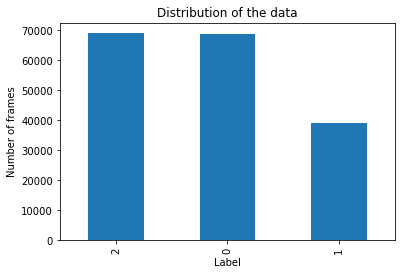

In [25]:
df_train['Category'].value_counts().plot.bar()
plt.title('Distribution of the data')
plt.xlabel('Label')
plt.ylabel('Number of frames')
plt.show()

### The data set is slightly imbalanced, (there is less data for the Alone mode)

<AxesSubplot:>

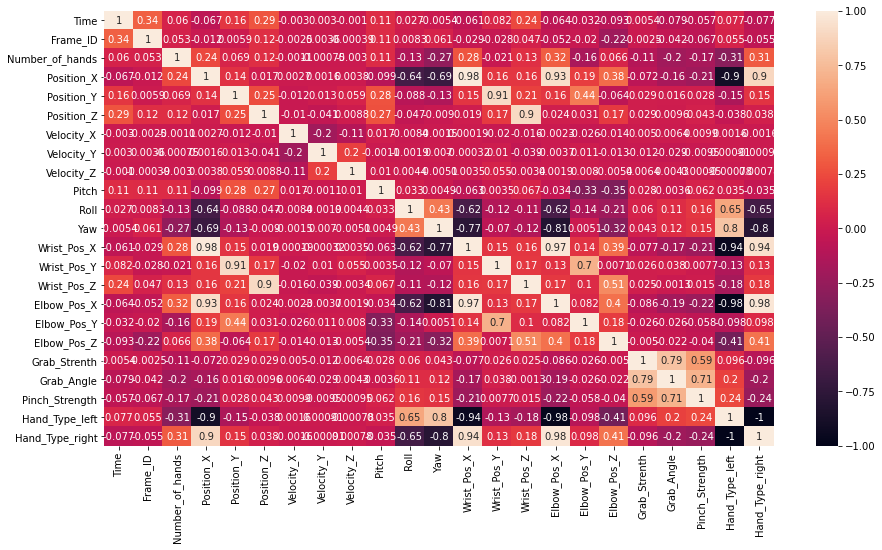

In [26]:
plt.figure(figsize=(15,8))
sns.heatmap(df_train.corr(),annot=True)

## Test (Validation) Set

### First, the syncronised mode:
### As you can see, I also got rid of the first seven seconds of each .csv file.

In [27]:
sync_test = []
file_path2 = r'C:\Users\yaron\Data Science\Validation'
for file_1 in os.listdir(file_path2):
    if file_1.endswith('Sync.csv'):
        sync_test.append(os.path.join(r'C:\Users\yaron\Data Science\Validation', file_1))
        
df_test_sync = pd.DataFrame()        
for file in sync_test:
    df5 = pd.read_csv(file)
    after_seven5 = df5['Time'] > (df5['Time'][0])+7
    df_after_seven5 = df5[after_seven5]
    df_after_seven5.reset_index(drop=True,inplace=True)
    df_after_seven5
    df_test_sync = pd.concat([df_test_sync,df_after_seven5])
df_test_sync

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,873.0052,101916,right,2,125.67840,232.6640,5.539143,-203.14320,404.92760,142.52930,...,0.189725,126.7503,179.9287,47.80795,222.4352,19.06148,198.3806,0.0,0.000000,0.0
1,873.0052,101916,left,2,-165.54570,210.9649,34.544110,-20.78199,141.12930,158.17200,...,0.422929,-184.7836,150.3946,57.01332,-323.1411,-12.50550,166.6798,0.0,0.000000,0.0
2,873.0218,101918,right,2,121.96130,238.2120,8.282627,-180.92320,336.21880,176.34840,...,0.169112,124.2761,183.5448,48.00742,222.1145,14.49698,187.8518,0.0,0.000000,0.0
3,873.0218,101918,left,2,-166.27120,213.6761,37.096450,-41.68034,146.74810,152.49840,...,0.407189,-184.3011,152.1136,57.66708,-320.6704,-13.19601,166.2126,0.0,0.000000,0.0
4,873.0384,101919,right,2,120.59450,240.5899,10.272620,-157.77620,274.48410,229.71140,...,0.169102,123.1464,184.8697,48.46577,223.1355,13.36058,183.7166,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,998.8158,66221,left,2,-96.74767,323.8981,76.983160,27.14988,185.62180,33.74187,...,1.632054,-145.1963,267.8716,68.90888,-298.0420,57.52314,124.0967,0.0,0.075099,0.0
4020,998.8495,66224,right,2,111.83100,324.5124,102.834100,86.42312,119.68330,-13.67371,...,-1.418975,163.0329,269.7217,103.07490,340.7914,72.96347,121.5707,0.0,0.024162,0.0
4021,998.8495,66224,left,2,-95.67720,329.8123,78.133160,47.37696,118.31670,24.15247,...,1.631368,-143.7923,273.4537,69.90453,-300.8497,65.10999,120.6967,0.0,0.029208,0.0
4022,998.8855,66227,right,2,113.80260,325.5213,101.486000,54.98372,11.75017,-37.26006,...,-1.432370,165.0616,270.7919,101.25900,344.8011,75.97822,121.1411,0.0,0.025365,0.0


In [28]:
df_test_sync = pd.get_dummies(df_test_sync)
df_test_sync

,Time,Frame ID,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,...,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength,Hand Type_left,Hand Type_right
0,873.0052,101916,2,125.67840,232.6640,5.539143,-203.14320,404.92760,142.52930,0.802115,...,179.9287,47.80795,222.4352,19.06148,198.3806,0.0,0.000000,0.0,0,1
1,873.0052,101916,2,-165.54570,210.9649,34.544110,-20.78199,141.12930,158.17200,1.118148,...,150.3946,57.01332,-323.1411,-12.50550,166.6798,0.0,0.000000,0.0,1,0
2,873.0218,101918,2,121.96130,238.2120,8.282627,-180.92320,336.21880,176.34840,0.847028,...,183.5448,48.00742,222.1145,14.49698,187.8518,0.0,0.000000,0.0,0,1
3,873.0218,101918,2,-166.27120,213.6761,37.096450,-41.68034,146.74810,152.49840,1.155207,...,152.1136,57.66708,-320.6704,-13.19601,166.2126,0.0,0.000000,0.0,1,0
4,873.0384,101919,2,120.59450,240.5899,10.272620,-157.77620,274.48410,229.71140,0.874375,...,184.8697,48.46577,223.1355,13.36058,183.7166,0.0,0.000000,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,998.8158,66221,2,-96.74767,323.8981,76.983160,27.14988,185.62180,33.74187,1.619489,...,267.8716,68.90888,-298.0420,57.52314,124.0967,0.0,0.075099,0.0,1,0
4020,998.8495,66224,2,111.83100,324.5124,102.834100,86.42312,119.68330,-13.67371,1.450944,...,269.7217,103.07490,340.7914,72.96347,121.5707,0.0,0.024162,0.0,0,1
4021,998.8495,66224,2,-95.67720,329.8123,78.133160,47.37696,118.31670,24.15247,1.618042,...,273.4537,69.90453,-300.8497,65.10999,120.6967,0.0,0.029208,0.0,1,0
4022,998.8855,66227,2,113.80260,325.5213,101.486000,54.98372,11.75017,-37.26006,1.461750,...,270.7919,101.25900,344.8011,75.97822,121.1411,0.0,0.025365,0.0,0,1


In [29]:
df_test_sync = df_test_sync.rename(columns={' Frame ID': 'Frame_ID', ' Hand Type_left': 'Hand_Type_left',' Hand Type_right': 'Hand_Type_right',
                                  ' # hands':'Number_of_hands', ' Position X': 'Position_X', ' Position Y': 'Position_Y',
                                ' Position Z': 'Position_Z', ' Velocity X': 'Velocity_X', ' Velocity Y': 'Velocity_Y',
                                ' Velocity Z': 'Velocity_Z', ' Wrist Pos X': 'Wrist_Pos_X', ' Wrist Pos Y': 'Wrist_Pos_Y', ' Wrist Pos Z': 'Wrist_Pos_Z',
                                 ' Elbow pos X': 'Elbow_Pos_X',  ' Elbow Pos Y':  'Elbow_Pos_Y', ' Elbow Pos Z': 'Elbow_Pos_Z',
                                 ' Grab Strenth': 'Grab_Strenth', ' Grab Angle': 'Grab_Angle', ' Pinch Strength': 'Pinch_Strength'})
df_test_sync['Category'] = '0'
df_test_sync

,Time,Frame_ID,Number_of_hands,Position_X,Position_Y,Position_Z,Velocity_X,Velocity_Y,Velocity_Z,Pitch,...,Wrist_Pos_Z,Elbow_Pos_X,Elbow_Pos_Y,Elbow_Pos_Z,Grab_Strenth,Grab_Angle,Pinch_Strength,Hand_Type_left,Hand_Type_right,Category
0,873.0052,101916,2,125.67840,232.6640,5.539143,-203.14320,404.92760,142.52930,0.802115,...,47.80795,222.4352,19.06148,198.3806,0.0,0.000000,0.0,0,1,0
1,873.0052,101916,2,-165.54570,210.9649,34.544110,-20.78199,141.12930,158.17200,1.118148,...,57.01332,-323.1411,-12.50550,166.6798,0.0,0.000000,0.0,1,0,0
2,873.0218,101918,2,121.96130,238.2120,8.282627,-180.92320,336.21880,176.34840,0.847028,...,48.00742,222.1145,14.49698,187.8518,0.0,0.000000,0.0,0,1,0
3,873.0218,101918,2,-166.27120,213.6761,37.096450,-41.68034,146.74810,152.49840,1.155207,...,57.66708,-320.6704,-13.19601,166.2126,0.0,0.000000,0.0,1,0,0
4,873.0384,101919,2,120.59450,240.5899,10.272620,-157.77620,274.48410,229.71140,0.874375,...,48.46577,223.1355,13.36058,183.7166,0.0,0.000000,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,998.8158,66221,2,-96.74767,323.8981,76.983160,27.14988,185.62180,33.74187,1.619489,...,68.90888,-298.0420,57.52314,124.0967,0.0,0.075099,0.0,1,0,0
4020,998.8495,66224,2,111.83100,324.5124,102.834100,86.42312,119.68330,-13.67371,1.450944,...,103.07490,340.7914,72.96347,121.5707,0.0,0.024162,0.0,0,1,0
4021,998.8495,66224,2,-95.67720,329.8123,78.133160,47.37696,118.31670,24.15247,1.618042,...,69.90453,-300.8497,65.10999,120.6967,0.0,0.029208,0.0,1,0,0
4022,998.8855,66227,2,113.80260,325.5213,101.486000,54.98372,11.75017,-37.26006,1.461750,...,101.25900,344.8011,75.97822,121.1411,0.0,0.025365,0.0,0,1,0


### Now, the alone mode:
### As you can see, I also got rid of the first seven seconds of each .csv file.

In [30]:
alone_test = []
for file_2 in os.listdir(file_path2):
    if file_2.endswith('Alone.csv'):
        alone_test.append(os.path.join(r'C:\Users\yaron\Data Science\Validation', file_2))
        
df_test_alone = pd.DataFrame()        
for file in alone_test:
    df6 = pd.read_csv(file)
    after_seven6 = df6['Time'] > (df6['Time'][0])+7
    df_after_seven6 = df6[after_seven6]
    df_after_seven6.reset_index(drop=True,inplace=True)
    df_after_seven6
    df_test_alone = pd.concat([df_test_alone,df_after_seven6])
df_test_alone

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,962.0724,112175,left,1,-139.56040,289.5980,55.82040,85.41927,-314.15190,-17.789130,...,1.327694,-200.4914,261.7830,63.46514,-379.1310,110.43980,116.0856,0.000000,0.911471,0.0
1,962.0892,112177,left,1,-137.84700,284.6244,55.60830,98.89174,-268.35150,-9.115684,...,1.326555,-199.0760,257.3272,63.25856,-383.5433,112.63620,114.6168,0.000000,0.909256,0.0
2,962.1058,112179,left,1,-135.24040,278.1614,55.07768,178.59840,-410.27810,-36.843320,...,1.329647,-196.5786,251.0247,62.48919,-381.9569,106.81380,111.8799,0.000000,0.927328,0.0
3,962.1220,112181,left,1,-131.68600,270.3371,54.44700,211.49920,-477.68290,-41.604380,...,1.334645,-194.7839,247.8369,62.06263,-384.9341,110.54120,112.9955,0.000000,0.950314,0.0
4,962.1385,112183,left,1,-128.48180,263.2296,53.83574,181.64070,-393.89460,-33.762600,...,1.341400,-191.7350,241.1172,61.10778,-381.3579,103.24660,112.4520,0.016646,1.015807,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034,796.7517,50329,left,1,-62.14733,282.7198,62.15659,-90.00631,-129.34680,-50.105870,...,0.853153,-107.4325,230.6662,88.71685,-297.5073,60.94059,148.1517,0.000000,0.149477,0.0
2035,796.7842,50331,left,1,-64.38816,276.7341,60.39418,-51.70352,-204.26430,-56.992680,...,0.791928,-108.3709,224.7578,89.17332,-293.6125,50.64548,151.1262,0.000000,0.205101,0.0
2036,796.8187,50333,left,1,-65.33954,272.7191,59.17199,-27.79678,-111.88810,-42.745720,...,0.758811,-108.3173,220.3898,88.81828,-290.7480,44.09612,152.9062,0.000000,0.304604,0.0
2037,796.8510,50336,left,1,-67.02361,268.6757,57.91473,-31.61606,-76.33112,-24.734110,...,0.730031,-108.7151,215.5677,88.03761,-285.7091,36.18958,158.4956,0.000000,0.374116,0.0


In [31]:
df_test_alone = pd.get_dummies(df_test_alone)
df_test_alone

,Time,Frame ID,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,...,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength,Hand Type_left,Hand Type_right
0,962.0724,112175,1,-139.56040,289.5980,55.82040,85.41927,-314.15190,-17.789130,1.073130,...,261.7830,63.46514,-379.1310,110.43980,116.0856,0.000000,0.911471,0.0,1,0
1,962.0892,112177,1,-137.84700,284.6244,55.60830,98.89174,-268.35150,-9.115684,1.064543,...,257.3272,63.25856,-383.5433,112.63620,114.6168,0.000000,0.909256,0.0,1,0
2,962.1058,112179,1,-135.24040,278.1614,55.07768,178.59840,-410.27810,-36.843320,1.066204,...,251.0247,62.48919,-381.9569,106.81380,111.8799,0.000000,0.927328,0.0,1,0
3,962.1220,112181,1,-131.68600,270.3371,54.44700,211.49920,-477.68290,-41.604380,0.972191,...,247.8369,62.06263,-384.9341,110.54120,112.9955,0.000000,0.950314,0.0,1,0
4,962.1385,112183,1,-128.48180,263.2296,53.83574,181.64070,-393.89460,-33.762600,0.971832,...,241.1172,61.10778,-381.3579,103.24660,112.4520,0.016646,1.015807,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034,796.7517,50329,1,-62.14733,282.7198,62.15659,-90.00631,-129.34680,-50.105870,1.075124,...,230.6662,88.71685,-297.5073,60.94059,148.1517,0.000000,0.149477,0.0,1,0
2035,796.7842,50331,1,-64.38816,276.7341,60.39418,-51.70352,-204.26430,-56.992680,1.034970,...,224.7578,89.17332,-293.6125,50.64548,151.1262,0.000000,0.205101,0.0,1,0
2036,796.8187,50333,1,-65.33954,272.7191,59.17199,-27.79678,-111.88810,-42.745720,1.020301,...,220.3898,88.81828,-290.7480,44.09612,152.9062,0.000000,0.304604,0.0,1,0
2037,796.8510,50336,1,-67.02361,268.6757,57.91473,-31.61606,-76.33112,-24.734110,1.014676,...,215.5677,88.03761,-285.7091,36.18958,158.4956,0.000000,0.374116,0.0,1,0


In [32]:
df_test_alone = df_test_alone.rename(columns={' Frame ID': 'Frame_ID', ' Hand Type_left': 'Hand_Type_left',' Hand Type_right': 'Hand_Type_right',
                                  ' # hands':'Number_of_hands', ' Position X': 'Position_X', ' Position Y': 'Position_Y',
                                ' Position Z': 'Position_Z', ' Velocity X': 'Velocity_X', ' Velocity Y': 'Velocity_Y',
                                ' Velocity Z': 'Velocity_Z', ' Wrist Pos X': 'Wrist_Pos_X', ' Wrist Pos Y': 'Wrist_Pos_Y', ' Wrist Pos Z': 'Wrist_Pos_Z',
                                 ' Elbow pos X': 'Elbow_Pos_X',  ' Elbow Pos Y':  'Elbow_Pos_Y', ' Elbow Pos Z': 'Elbow_Pos_Z',
                                 ' Grab Strenth': 'Grab_Strenth', ' Grab Angle': 'Grab_Angle', ' Pinch Strength': 'Pinch_Strength'})
df_test_alone['Category'] = '1'
df_test_alone

,Time,Frame_ID,Number_of_hands,Position_X,Position_Y,Position_Z,Velocity_X,Velocity_Y,Velocity_Z,Pitch,...,Wrist_Pos_Z,Elbow_Pos_X,Elbow_Pos_Y,Elbow_Pos_Z,Grab_Strenth,Grab_Angle,Pinch_Strength,Hand_Type_left,Hand_Type_right,Category
0,962.0724,112175,1,-139.56040,289.5980,55.82040,85.41927,-314.15190,-17.789130,1.073130,...,63.46514,-379.1310,110.43980,116.0856,0.000000,0.911471,0.0,1,0,1
1,962.0892,112177,1,-137.84700,284.6244,55.60830,98.89174,-268.35150,-9.115684,1.064543,...,63.25856,-383.5433,112.63620,114.6168,0.000000,0.909256,0.0,1,0,1
2,962.1058,112179,1,-135.24040,278.1614,55.07768,178.59840,-410.27810,-36.843320,1.066204,...,62.48919,-381.9569,106.81380,111.8799,0.000000,0.927328,0.0,1,0,1
3,962.1220,112181,1,-131.68600,270.3371,54.44700,211.49920,-477.68290,-41.604380,0.972191,...,62.06263,-384.9341,110.54120,112.9955,0.000000,0.950314,0.0,1,0,1
4,962.1385,112183,1,-128.48180,263.2296,53.83574,181.64070,-393.89460,-33.762600,0.971832,...,61.10778,-381.3579,103.24660,112.4520,0.016646,1.015807,0.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034,796.7517,50329,1,-62.14733,282.7198,62.15659,-90.00631,-129.34680,-50.105870,1.075124,...,88.71685,-297.5073,60.94059,148.1517,0.000000,0.149477,0.0,1,0,1
2035,796.7842,50331,1,-64.38816,276.7341,60.39418,-51.70352,-204.26430,-56.992680,1.034970,...,89.17332,-293.6125,50.64548,151.1262,0.000000,0.205101,0.0,1,0,1
2036,796.8187,50333,1,-65.33954,272.7191,59.17199,-27.79678,-111.88810,-42.745720,1.020301,...,88.81828,-290.7480,44.09612,152.9062,0.000000,0.304604,0.0,1,0,1
2037,796.8510,50336,1,-67.02361,268.6757,57.91473,-31.61606,-76.33112,-24.734110,1.014676,...,88.03761,-285.7091,36.18958,158.4956,0.000000,0.374116,0.0,1,0,1


### Finally, the spontanious mode:
### As you can see, I also got rid of the first seven seconds of each .csv file.

In [33]:
spontan_test = []
for file_3 in os.listdir(file_path2):
    if file_3.endswith('Sync.csv'):
        spontan_test.append(os.path.join(r'C:\Users\yaron\Data Science\Validation', file_3))
        
df_test_spontan = pd.DataFrame()        
for file in spontan_test:
    df7 = pd.read_csv(file)
    after_seven7 = df7['Time'] > (df7['Time'][0])+7
    df_after_seven7 = df7[after_seven7]
    df_after_seven7.reset_index(drop=True,inplace=True)
    df_after_seven7
    df_test_spontan = pd.concat([df_test_spontan,df_after_seven7])
df_test_spontan

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,873.0052,101916,right,2,125.67840,232.6640,5.539143,-203.14320,404.92760,142.52930,...,0.189725,126.7503,179.9287,47.80795,222.4352,19.06148,198.3806,0.0,0.000000,0.0
1,873.0052,101916,left,2,-165.54570,210.9649,34.544110,-20.78199,141.12930,158.17200,...,0.422929,-184.7836,150.3946,57.01332,-323.1411,-12.50550,166.6798,0.0,0.000000,0.0
2,873.0218,101918,right,2,121.96130,238.2120,8.282627,-180.92320,336.21880,176.34840,...,0.169112,124.2761,183.5448,48.00742,222.1145,14.49698,187.8518,0.0,0.000000,0.0
3,873.0218,101918,left,2,-166.27120,213.6761,37.096450,-41.68034,146.74810,152.49840,...,0.407189,-184.3011,152.1136,57.66708,-320.6704,-13.19601,166.2126,0.0,0.000000,0.0
4,873.0384,101919,right,2,120.59450,240.5899,10.272620,-157.77620,274.48410,229.71140,...,0.169102,123.1464,184.8697,48.46577,223.1355,13.36058,183.7166,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,998.8158,66221,left,2,-96.74767,323.8981,76.983160,27.14988,185.62180,33.74187,...,1.632054,-145.1963,267.8716,68.90888,-298.0420,57.52314,124.0967,0.0,0.075099,0.0
4020,998.8495,66224,right,2,111.83100,324.5124,102.834100,86.42312,119.68330,-13.67371,...,-1.418975,163.0329,269.7217,103.07490,340.7914,72.96347,121.5707,0.0,0.024162,0.0
4021,998.8495,66224,left,2,-95.67720,329.8123,78.133160,47.37696,118.31670,24.15247,...,1.631368,-143.7923,273.4537,69.90453,-300.8497,65.10999,120.6967,0.0,0.029208,0.0
4022,998.8855,66227,right,2,113.80260,325.5213,101.486000,54.98372,11.75017,-37.26006,...,-1.432370,165.0616,270.7919,101.25900,344.8011,75.97822,121.1411,0.0,0.025365,0.0


In [34]:
df_test_spontan = pd.get_dummies(df_test_spontan)
df_test_spontan

,Time,Frame ID,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,...,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength,Hand Type_left,Hand Type_right
0,873.0052,101916,2,125.67840,232.6640,5.539143,-203.14320,404.92760,142.52930,0.802115,...,179.9287,47.80795,222.4352,19.06148,198.3806,0.0,0.000000,0.0,0,1
1,873.0052,101916,2,-165.54570,210.9649,34.544110,-20.78199,141.12930,158.17200,1.118148,...,150.3946,57.01332,-323.1411,-12.50550,166.6798,0.0,0.000000,0.0,1,0
2,873.0218,101918,2,121.96130,238.2120,8.282627,-180.92320,336.21880,176.34840,0.847028,...,183.5448,48.00742,222.1145,14.49698,187.8518,0.0,0.000000,0.0,0,1
3,873.0218,101918,2,-166.27120,213.6761,37.096450,-41.68034,146.74810,152.49840,1.155207,...,152.1136,57.66708,-320.6704,-13.19601,166.2126,0.0,0.000000,0.0,1,0
4,873.0384,101919,2,120.59450,240.5899,10.272620,-157.77620,274.48410,229.71140,0.874375,...,184.8697,48.46577,223.1355,13.36058,183.7166,0.0,0.000000,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,998.8158,66221,2,-96.74767,323.8981,76.983160,27.14988,185.62180,33.74187,1.619489,...,267.8716,68.90888,-298.0420,57.52314,124.0967,0.0,0.075099,0.0,1,0
4020,998.8495,66224,2,111.83100,324.5124,102.834100,86.42312,119.68330,-13.67371,1.450944,...,269.7217,103.07490,340.7914,72.96347,121.5707,0.0,0.024162,0.0,0,1
4021,998.8495,66224,2,-95.67720,329.8123,78.133160,47.37696,118.31670,24.15247,1.618042,...,273.4537,69.90453,-300.8497,65.10999,120.6967,0.0,0.029208,0.0,1,0
4022,998.8855,66227,2,113.80260,325.5213,101.486000,54.98372,11.75017,-37.26006,1.461750,...,270.7919,101.25900,344.8011,75.97822,121.1411,0.0,0.025365,0.0,0,1


In [35]:
df_test_spontan = df_test_spontan.rename(columns={' Frame ID': 'Frame_ID', ' Hand Type_left': 'Hand_Type_left',' Hand Type_right': 'Hand_Type_right',
                                  ' # hands':'Number_of_hands', ' Position X': 'Position_X', ' Position Y': 'Position_Y',
                                ' Position Z': 'Position_Z', ' Velocity X': 'Velocity_X', ' Velocity Y': 'Velocity_Y',
                                ' Velocity Z': 'Velocity_Z', ' Wrist Pos X': 'Wrist_Pos_X', ' Wrist Pos Y': 'Wrist_Pos_Y', ' Wrist Pos Z': 'Wrist_Pos_Z',
                                 ' Elbow pos X': 'Elbow_Pos_X',  ' Elbow Pos Y':  'Elbow_Pos_Y', ' Elbow Pos Z': 'Elbow_Pos_Z',
                                 ' Grab Strenth': 'Grab_Strenth', ' Grab Angle': 'Grab_Angle', ' Pinch Strength': 'Pinch_Strength'})
df_test_spontan['Category'] = '2'
df_test_spontan

,Time,Frame_ID,Number_of_hands,Position_X,Position_Y,Position_Z,Velocity_X,Velocity_Y,Velocity_Z,Pitch,...,Wrist_Pos_Z,Elbow_Pos_X,Elbow_Pos_Y,Elbow_Pos_Z,Grab_Strenth,Grab_Angle,Pinch_Strength,Hand_Type_left,Hand_Type_right,Category
0,873.0052,101916,2,125.67840,232.6640,5.539143,-203.14320,404.92760,142.52930,0.802115,...,47.80795,222.4352,19.06148,198.3806,0.0,0.000000,0.0,0,1,2
1,873.0052,101916,2,-165.54570,210.9649,34.544110,-20.78199,141.12930,158.17200,1.118148,...,57.01332,-323.1411,-12.50550,166.6798,0.0,0.000000,0.0,1,0,2
2,873.0218,101918,2,121.96130,238.2120,8.282627,-180.92320,336.21880,176.34840,0.847028,...,48.00742,222.1145,14.49698,187.8518,0.0,0.000000,0.0,0,1,2
3,873.0218,101918,2,-166.27120,213.6761,37.096450,-41.68034,146.74810,152.49840,1.155207,...,57.66708,-320.6704,-13.19601,166.2126,0.0,0.000000,0.0,1,0,2
4,873.0384,101919,2,120.59450,240.5899,10.272620,-157.77620,274.48410,229.71140,0.874375,...,48.46577,223.1355,13.36058,183.7166,0.0,0.000000,0.0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,998.8158,66221,2,-96.74767,323.8981,76.983160,27.14988,185.62180,33.74187,1.619489,...,68.90888,-298.0420,57.52314,124.0967,0.0,0.075099,0.0,1,0,2
4020,998.8495,66224,2,111.83100,324.5124,102.834100,86.42312,119.68330,-13.67371,1.450944,...,103.07490,340.7914,72.96347,121.5707,0.0,0.024162,0.0,0,1,2
4021,998.8495,66224,2,-95.67720,329.8123,78.133160,47.37696,118.31670,24.15247,1.618042,...,69.90453,-300.8497,65.10999,120.6967,0.0,0.029208,0.0,1,0,2
4022,998.8855,66227,2,113.80260,325.5213,101.486000,54.98372,11.75017,-37.26006,1.461750,...,101.25900,344.8011,75.97822,121.1411,0.0,0.025365,0.0,0,1,2


In [36]:
df_test = pd.concat([df_test_sync, df_train_alone], axis=0, ignore_index=True)
df_test
df_test = pd.concat([df_test, df_test_spontan], axis=0, ignore_index=True)
df_test

,Time,Frame_ID,Number_of_hands,Position_X,Position_Y,Position_Z,Velocity_X,Velocity_Y,Velocity_Z,Pitch,...,Wrist_Pos_Z,Elbow_Pos_X,Elbow_Pos_Y,Elbow_Pos_Z,Grab_Strenth,Grab_Angle,Pinch_Strength,Hand_Type_left,Hand_Type_right,Category
0,873.0052,101916,2,125.67840,232.6640,5.539143,-203.14320,404.92760,142.52930,0.802115,...,47.80795,222.4352,19.06148,198.3806,0.0,0.000000,0.0,0,1,0
1,873.0052,101916,2,-165.54570,210.9649,34.544110,-20.78199,141.12930,158.17200,1.118148,...,57.01332,-323.1411,-12.50550,166.6798,0.0,0.000000,0.0,1,0,0
2,873.0218,101918,2,121.96130,238.2120,8.282627,-180.92320,336.21880,176.34840,0.847028,...,48.00742,222.1145,14.49698,187.8518,0.0,0.000000,0.0,0,1,0
3,873.0218,101918,2,-166.27120,213.6761,37.096450,-41.68034,146.74810,152.49840,1.155207,...,57.66708,-320.6704,-13.19601,166.2126,0.0,0.000000,0.0,1,0,0
4,873.0384,101919,2,120.59450,240.5899,10.272620,-157.77620,274.48410,229.71140,0.874375,...,48.46577,223.1355,13.36058,183.7166,0.0,0.000000,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79706,998.8158,66221,2,-96.74767,323.8981,76.983160,27.14988,185.62180,33.74187,1.619489,...,68.90888,-298.0420,57.52314,124.0967,0.0,0.075099,0.0,1,0,2
79707,998.8495,66224,2,111.83100,324.5124,102.834100,86.42312,119.68330,-13.67371,1.450944,...,103.07490,340.7914,72.96347,121.5707,0.0,0.024162,0.0,0,1,2
79708,998.8495,66224,2,-95.67720,329.8123,78.133160,47.37696,118.31670,24.15247,1.618042,...,69.90453,-300.8497,65.10999,120.6967,0.0,0.029208,0.0,1,0,2
79709,998.8855,66227,2,113.80260,325.5213,101.486000,54.98372,11.75017,-37.26006,1.461750,...,101.25900,344.8011,75.97822,121.1411,0.0,0.025365,0.0,0,1,2


In [37]:
df_test.isna().sum()

Time                 0
Frame_ID             0
Number_of_hands      0
Position_X           0
Position_Y           0
Position_Z           0
Velocity_X           0
Velocity_Y           0
Velocity_Z           0
 Pitch               0
 Roll                0
 Yaw                 0
Wrist_Pos_X        384
Wrist_Pos_Y        384
Wrist_Pos_Z        384
Elbow_Pos_X        384
Elbow_Pos_Y        384
Elbow_Pos_Z        384
Grab_Strenth         0
Grab_Angle           0
Pinch_Strength       0
Hand_Type_left       0
Hand_Type_right      0
Category             0
dtype: int64

### The percentage of NaN values is so small, I can easily drop them.

In [38]:
df_test.dropna(how='any', inplace=True)

## Let's count the values of each category:

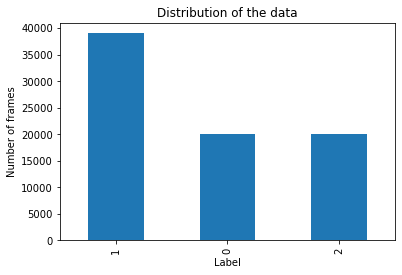

In [39]:
df_test['Category'].value_counts().plot.bar()
plt.title('Distribution of the data')
plt.xlabel('Label')
plt.ylabel('Number of frames')
plt.show()

### The Test set is more imbalanced. I can't get more data, so we I have to work with this.

## Split to Training and Testing

In [40]:
x_train = (df_train.drop(columns = 'Category'))
y_train = (df_train['Category'])
x_test = (df_test.drop(columns = 'Category'))
y_test = (df_test['Category'])

## Scaling

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Model - Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred1 = rf.predict(x_test)

### Accuracy Check

              precision    recall  f1-score   support

           0       0.50      0.60      0.55     20143
           1       1.00      1.00      1.00     39041
           2       0.50      0.40      0.44     20143

    accuracy                           0.75     79327
   macro avg       0.67      0.67      0.66     79327
weighted avg       0.75      0.75      0.74     79327

Accuracy:  0.7460133371991882


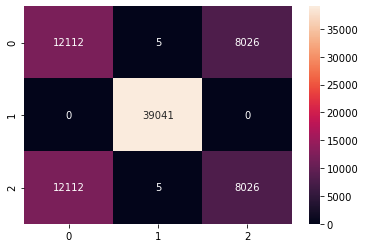

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
confmat1 = confusion_matrix(y_test, y_pred1)
sns.heatmap(confmat1, annot = True, fmt = "d")
class_rep1 = classification_report(y_test, y_pred1)
acc_score1 = accuracy_score(y_test, y_pred1)
print(class_rep1)
print("Accuracy: ", acc_score1)

## Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(x_train, y_train)
y_pred2 = dt.predict(x_test)

              precision    recall  f1-score   support

           0       0.50      0.65      0.56     20143
           1       0.94      1.00      0.97     39041
           2       0.50      0.29      0.37     20143

    accuracy                           0.73     79327
   macro avg       0.65      0.65      0.63     79327
weighted avg       0.72      0.73      0.71     79327

Accuracy:  0.7304574734957833


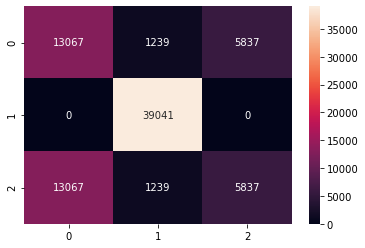

In [47]:
confmat2 = confusion_matrix(y_test, y_pred2)
sns.heatmap(confmat2, annot = True, fmt = "d")
class_rep2 = classification_report(y_test, y_pred2)
acc_score2 = accuracy_score(y_test, y_pred2)
print(class_rep2)
print("Accuracy: ", acc_score2)

## Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(random_state=0)
lg.fit(x_train, y_train)
y_pred3 = lg.predict(x_test)

C:\Users\yaron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.50      0.59      0.54     20143
           1       0.99      0.98      0.99     39041
           2       0.49      0.40      0.44     20143

    accuracy                           0.74     79327
   macro avg       0.66      0.66      0.66     79327
weighted avg       0.74      0.74      0.74     79327

Accuracy:  0.7371386791382505


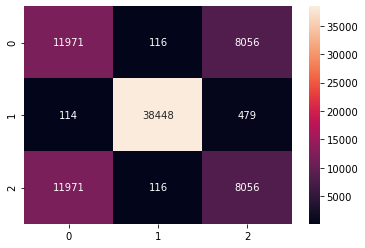

In [49]:
confmat3 = confusion_matrix(y_test, y_pred3)
sns.heatmap(confmat3, annot = True, fmt = "d")
class_rep3 = classification_report(y_test, y_pred3)
acc_score3 = accuracy_score(y_test, y_pred3)
print(class_rep3)
print("Accuracy: ", acc_score3)

## AdaBoost

In [50]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(x_train, y_train)
y_pred4 = ada.predict(x_test)

              precision    recall  f1-score   support

           0       0.50      0.82      0.62     20143
           1       0.85      0.99      0.92     39041
           2       0.36      0.01      0.01     20143

    accuracy                           0.70     79327
   macro avg       0.57      0.61      0.52     79327
weighted avg       0.64      0.70      0.61     79327

Accuracy:  0.7001147150402763


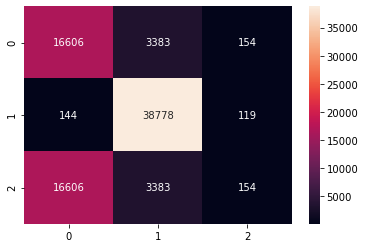

In [51]:
confmat4 = confusion_matrix(y_test, y_pred4)
sns.heatmap(confmat4, annot = True, fmt = "d")
class_rep4 = classification_report(y_test, y_pred4)
acc_score4 = accuracy_score(y_test, y_pred4)
print(class_rep4)
print("Accuracy: ", acc_score4)

## XGBoost

In [52]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
y_pred5 = xgb.predict(x_test)

C:\Users\yaron\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:02:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


              precision    recall  f1-score   support

           0       0.50      0.60      0.54     20143
           1       0.94      1.00      0.97     39041
           2       0.50      0.34      0.40     20143

    accuracy                           0.73     79327
   macro avg       0.65      0.64      0.64     79327
weighted avg       0.71      0.73      0.72     79327

Accuracy:  0.7293859593833121


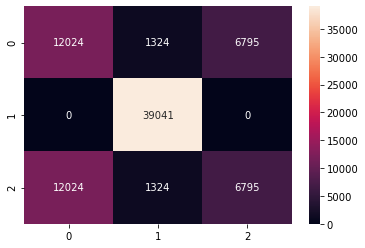

In [53]:
confmat5 = confusion_matrix(y_test, y_pred5)
sns.heatmap(confmat5, annot = True, fmt = "d")
class_rep5 = classification_report(y_test, y_pred5)
acc_score5 = accuracy_score(y_test, y_pred5)
print(class_rep5)
print("Accuracy: ", acc_score5)

## Dimensionality Reduction - PCA

In [55]:
from sklearn.decomposition import PCA
pca_24 = PCA(n_components=24)
pca_24.fit(df_train)
pca_24.fit(df_test)

PCA(n_components=24)

Text(0, 0.5, 'Explained variance')

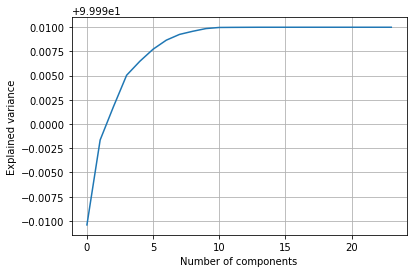

In [56]:
plt.grid()
plt.plot(np.cumsum(pca_24.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

In [61]:
pca_18 = PCA(n_components=18)
x_train_reduced = pca_18.fit_transform(x_train)
x_test_reduced = pca_18.fit_transform(x_test)
x_train_recovered = pca_18.inverse_transform(x_train_reduced)
x_test_recovered = pca_18.inverse_transform(x_test_reduced)

In [62]:
np.cumsum(pca_18.explained_variance_ratio_)[-1]

0.9974401597981928

## Train and test again

In [64]:
rf.fit(x_train_reduced, y_train)
y_pred6 = rf.predict(x_test_reduced)
dt.fit(x_train_reduced, y_train)
y_pred7 = dt.predict(x_test_reduced)
lg.fit(x_train_reduced, y_train)
y_pred8 = lg.predict(x_test_reduced)
ada.fit(x_train_reduced, y_train)
y_pred9 = ada.predict(x_test_reduced)
xgb.fit(x_train_reduced, y_train)
y_pred10 = xgb.predict(x_test_reduced)

C:\Users\yaron\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:12:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


              precision    recall  f1-score   support

           0       0.29      0.33      0.31     20143
           1       0.73      0.34      0.46     39041
           2       0.29      0.55      0.38     20143

    accuracy                           0.39     79327
   macro avg       0.44      0.41      0.38     79327
weighted avg       0.51      0.39      0.40     79327

Accuracy:  0.3886822897626281


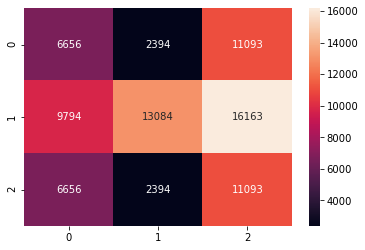

In [66]:
confmat6 = confusion_matrix(y_test, y_pred6)
sns.heatmap(confmat6, annot = True, fmt = "d")
class_rep6 = classification_report(y_test, y_pred6)
acc_score6 = accuracy_score(y_test, y_pred6)
print(class_rep6)
print("Accuracy: ", acc_score6)

              precision    recall  f1-score   support

           0       0.28      0.37      0.32     20143
           1       0.66      0.29      0.40     39041
           2       0.27      0.48      0.35     20143

    accuracy                           0.36     79327
   macro avg       0.40      0.38      0.36     79327
weighted avg       0.47      0.36      0.37     79327

Accuracy:  0.3597261966291427


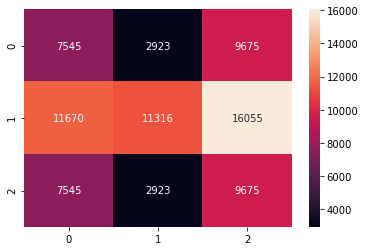

In [67]:
confmat7 = confusion_matrix(y_test, y_pred7)
sns.heatmap(confmat7, annot = True, fmt = "d")
class_rep7 = classification_report(y_test, y_pred7)
acc_score7 = accuracy_score(y_test, y_pred7)
print(class_rep7)
print("Accuracy: ", acc_score7)

              precision    recall  f1-score   support

           0       0.29      0.41      0.34     20143
           1       0.84      0.37      0.51     39041
           2       0.31      0.52      0.39     20143

    accuracy                           0.42     79327
   macro avg       0.48      0.43      0.41     79327
weighted avg       0.56      0.42      0.44     79327

Accuracy:  0.4164408082998223


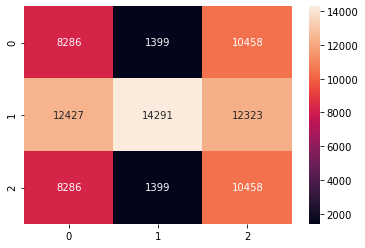

In [68]:
confmat8 = confusion_matrix(y_test, y_pred8)
sns.heatmap(confmat8, annot = True, fmt = "d")
class_rep8 = classification_report(y_test, y_pred8)
acc_score8 = accuracy_score(y_test, y_pred8)
print(class_rep8)
print("Accuracy: ", acc_score8)

              precision    recall  f1-score   support

           0       0.30      0.43      0.35     20143
           1       0.78      0.28      0.41     39041
           2       0.28      0.50      0.36     20143

    accuracy                           0.37     79327
   macro avg       0.45      0.40      0.37     79327
weighted avg       0.53      0.37      0.38     79327

Accuracy:  0.3728743050915829


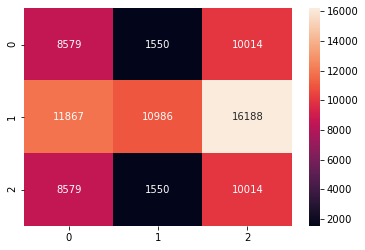

In [69]:
confmat9 = confusion_matrix(y_test, y_pred9)
sns.heatmap(confmat9, annot = True, fmt = "d")
class_rep9 = classification_report(y_test, y_pred9)
acc_score9 = accuracy_score(y_test, y_pred9)
print(class_rep9)
print("Accuracy: ", acc_score9)

              precision    recall  f1-score   support

           0       0.32      0.49      0.39     20143
           1       0.81      0.28      0.42     39041
           2       0.26      0.45      0.33     20143

    accuracy                           0.38     79327
   macro avg       0.46      0.41      0.38     79327
weighted avg       0.55      0.38      0.39     79327

Accuracy:  0.3754963631550418


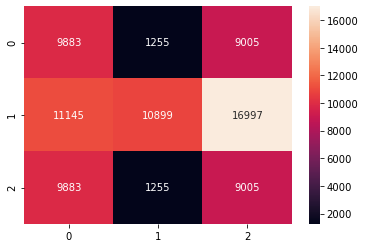

In [70]:
confmat10 = confusion_matrix(y_test, y_pred10)
sns.heatmap(confmat10, annot = True, fmt = "d")
class_rep10 = classification_report(y_test, y_pred10)
acc_score10 = accuracy_score(y_test, y_pred10)
print(class_rep10)
print("Accuracy: ", acc_score10)

## Conclusion

### The best accuracy I got was 73.7% with Logistic Regression
### 